<a href="https://colab.research.google.com/github/huachongxie/diffusion-models-class-CN/blob/main/unit1/02_diffusion_models_from_scratch_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 从零开始的扩散模型

有时，只考虑一些事务最简单的情况会有助于更好地理解其工作原理。我们将在本笔记本中尝试这一点，从“玩具”扩散模型开始，看看不同的部分是如何工作的，然后再检查它们与更复杂的实现有何不同。

我们将学习
- 损坏过程（向数据添加噪声）
- 什么是UNet，以及如何从零开始实现一个极小的UNet
- 扩散模型训练
- 抽样理论

然后，我们将比较我们的版本与diffusers库中的DDPM实现的区别
- 对小型UNet的改进
- DDPM噪声计划
- 训练目标的差异
- timestep调节
- 抽样方法

这个笔记本相当深入，如果你对从零开始的深入研究不感兴趣，可以放心地跳过！

还值得注意的是，这里的大多数代码都是出于说明的目的，我不建议直接将其用于您自己的工作（除非您只是为了学习目的而尝试改进这里展示的示例）。

## 准备环境与导入：

In [22]:
!pip install -q diffusers

In [21]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 数据

在这里，我们将使用一个非常小的经典数据集mnist来进行测试。如果您想在不改变任何其他内容的情况下给模型一个稍微困难一点的挑战，请使用torchvision.dataset。FashionMNIST应作为替代品。

In [23]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [24]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 3, 4, 5, 4, 1, 7, 9])


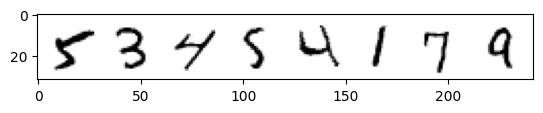

In [25]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

该数据集中的每张图都是一个数字的28x28像素的灰度图，像素值的范围事从0到1。

## 损坏过程

假设你没有读过任何扩散模型的论文，但你知道这个过程会增加噪声。你会怎么做？

我们可能想要一个简单的方法来控制损坏的程度。那么，如果我们要引入一个参数来控制输入的“噪声量”，那么我们会这么做：

`noise = torch.rand_like(x)`

`noisy_x =  (1-amount)*x + amount*noise`

如果 amount = 0，则返回输入而不做任何更改。如果 amount = 1，我们将得到一个纯粹的噪声。通过这种方式将输入与噪声混合，我们将输出保持在相同的范围（0 to 1）。

我们可以很容易地实现这一点（但是要注意tensor的shape，以防被广播(broadcasting)机制不正确的影响到）：

In [26]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

让我们来可视化一下输出的结果，以了解是否符合我们的预期：

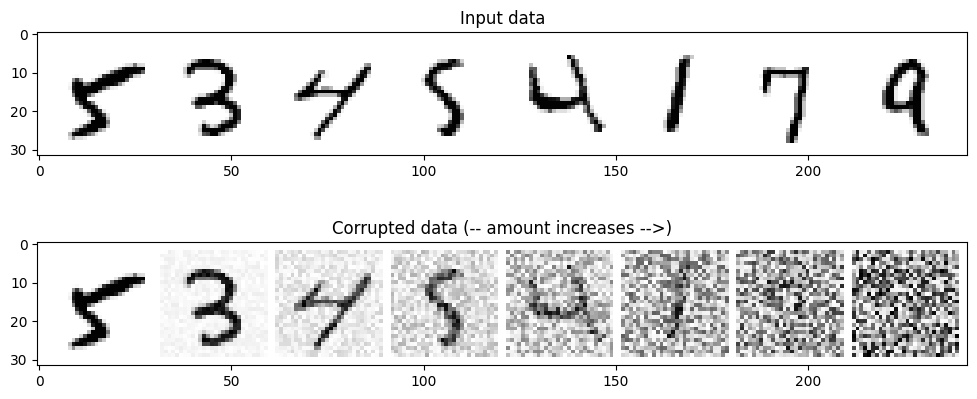

In [27]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plottinf the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

当噪声量接近1时，我们的数据开始看起来像纯随机噪声。但对于大多数的噪声情况下，您还是可以很好地识别出数字。你认为这是最佳的吗？

## 模型

我们想要一个模型，它可以接收28px的噪声图像，并输出相同形状的预测。一个比较流行的选择是一个叫做UNet的架构。[最初被发明用于医学图像中的分割任务](https://arxiv.org/abs/1505.04597)，UNet由一个“压缩路径”和一个“扩展路径”组成。“压缩路径”会使通过该路径的数据被压缩，而通过“扩展路径”会将数据扩展回原始维度（类似于自动编码器）。模型中的残差连接也允许信息和梯度在不同层级之间流动。

一些UNet的设计在每个阶段都有复杂的blocks，但对于这个玩具demo，我们只会构建一个最简单的示例，它接收一个单通道图像，并通过下行路径上的三个卷积层（图和代码中的down_layers）和上行路径上的3个卷积层，在下行和上行层之间具有残差连接。我们将使用max pooling进行下采样和`nn.Upsample`用于上采样。某些比较复杂的UNets的设计会使用带有可学习参数的上采样和下采样layer。下面的结构图大致展示了每个layer的输出通道数：

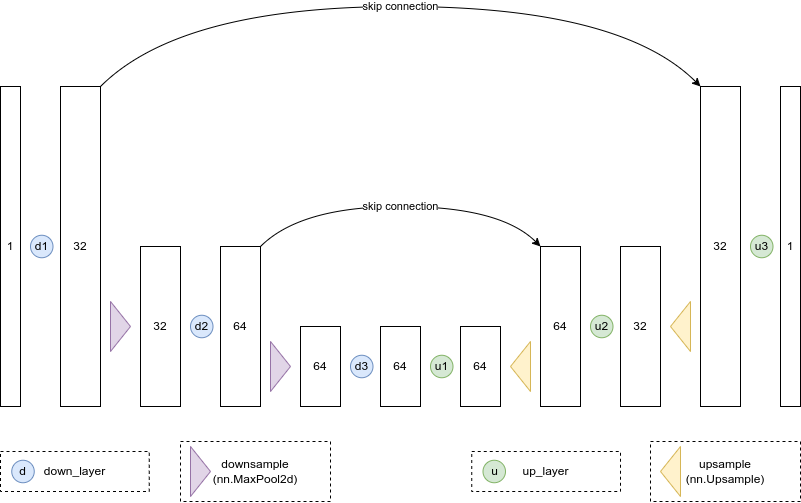

代码实现如下：

In [28]:
import torch.nn.init
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

我们可以验证输出shape是否如我们期望的那样与输入相同：

In [29]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

该网络有30多万个参数：

In [30]:
sum([p.numel() for p in net.parameters()])

309057

您可以尝试更改每个layer中的通道数或尝试不同的结构设计。

## 训练模型

那么，模型到底应该做什么呢？同样，对这个问题有各种不同的看法，但对于这个演示，让我们选择一个简单的框架：给定一个损坏的输入noisy_x，模型应该输出它对原本x的最佳猜测。我们将通过均方误差将预测与真实值进行比较。

我们现在可以尝试训练网络了。
- 获取一批数据
- 添加随机噪声
- 将数据输入模型
- 将模型预测与干净图像进行比较，以计算loss
- 更新模型的参数。

你可以自由进行修改来尝试获得更好的结果！

Finished epoch 0. Average loss for this epoch: 0.026615
Finished epoch 1. Average loss for this epoch: 0.020009
Finished epoch 2. Average loss for this epoch: 0.018403


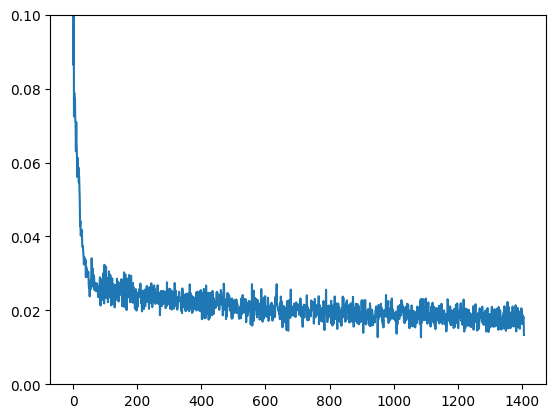

In [31]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        loss.backward()
        opt.step()
        opt.zero_grad()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

我们可以尝试通过抓取一批数据，以不同的数量损坏数据，然后喂进模型获得预测来观察结果：

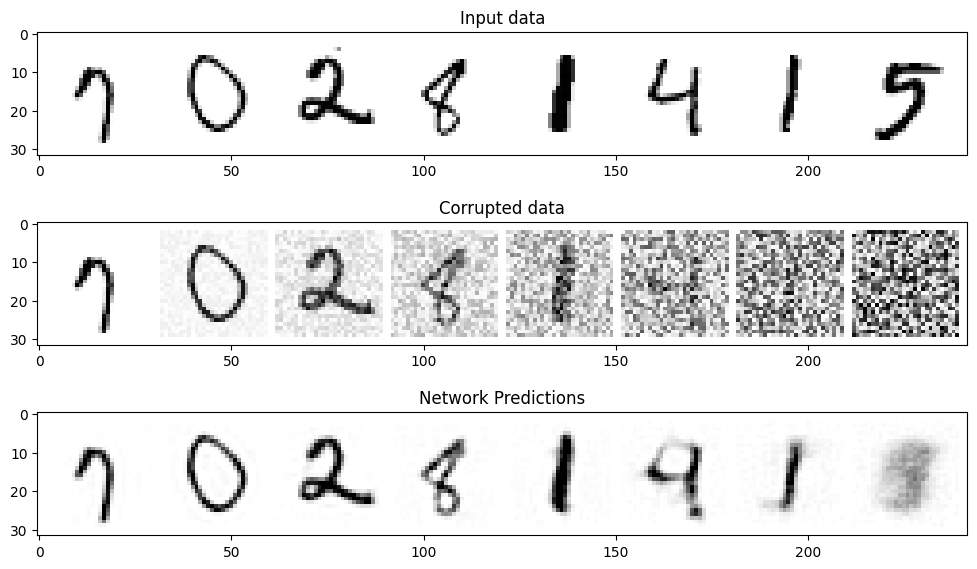

In [37]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

你可以看到，对于较低的噪声水平数量，预测的结果相当不错！但是，当噪声水平非常高时，模型能够获得的信息就开始逐渐减少。而当我们达到amount = 1时，模型会输出一个模糊的预测，该预测会很接近数据集的平均值。模型通过这样的方式来猜测原始输入。

## 取样（采样）

如果我们在高噪声水平下的预测不是很好，我们如何才能生成图像呢？

如果我们从完全随机的噪声开始，检查一下模型预测的结果，然后只朝着预测方向移动一小部分，比如说20%。现在我们有一个噪声很多的图像，其中可能隐藏了一些关于输入数据的结构的提示，我们可以将其输入到模型中以获得新的预测。希望这个新的预测比第一个稍微好一点（因为我们这一次的输入稍微减少了一点噪声），所以我们可以用这个新的更好的预测再往前迈出一小步。

如果一切顺利的话，以上过程重复几次以后我们就会得到一个新的图像！以下图例是迭代了五次以后的结果，左侧是每个阶段的模型输入的可视化，右侧则是预测的去噪图像。Note that even though the model predicts the denoised image even at step 1, we only move x part of the way there. 重复几次以后，图像的结构开始逐渐出现并得到改善,直到获得我们的最终结果为止。

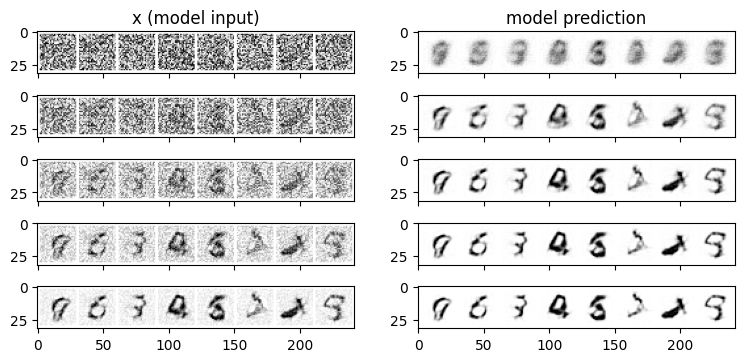

In [33]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

我们可以将流程分成更多步骤，并希望通过这种方式获得更好的图像：

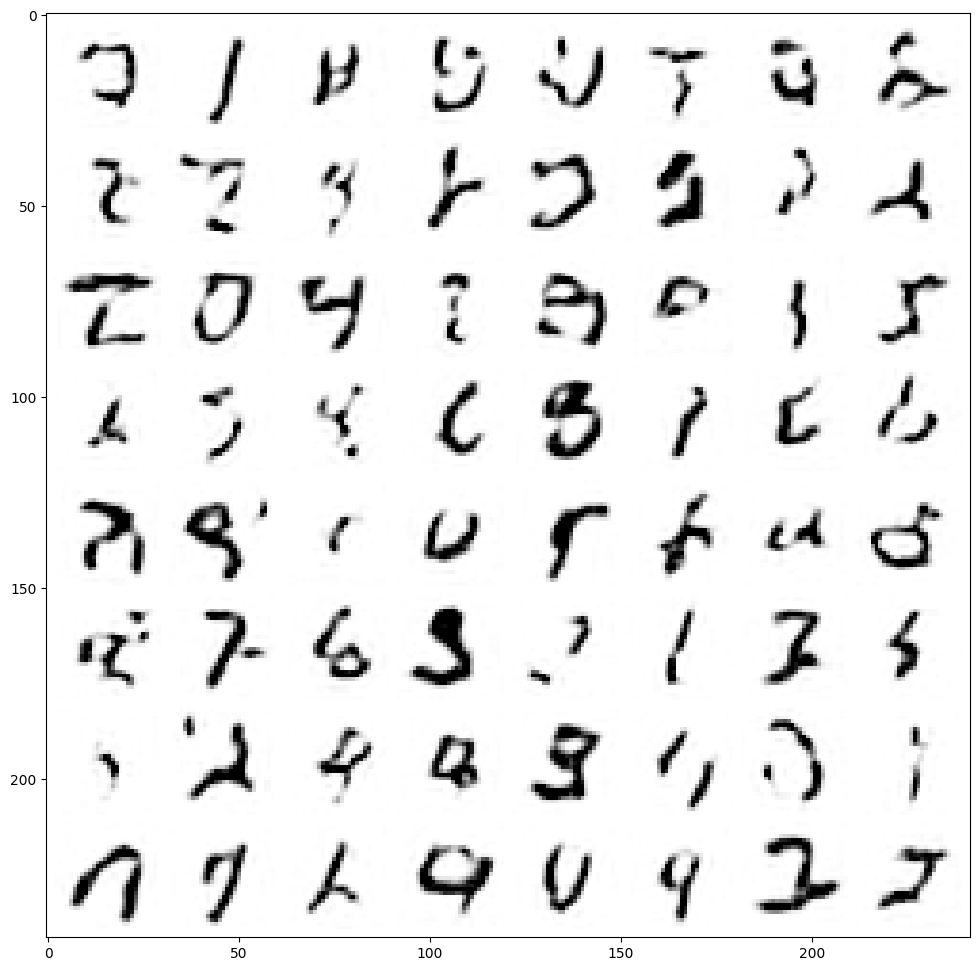

In [34]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

结果并不是非常好，但是已经出现了一些可以被认出来的数字！您可以尝试训练更长时间（例如，10或20个epoch），并调整模型配置、学习率、优化器等。此外，如果您想尝试稍微困难一点的数据集，您可以尝试一下fashionMNIST，只需要一行代码的替换就可以了。

## 与 DDPM 做比较

在本节中，我们将看看我们的“玩具”实现与其他笔记本中使用的基于DDPM论文的方法有何不同（[扩散器简介](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb))。

我们将会看到的

*   模型的表现受限于随迭代周期(timesteps)变化的控制条件，在前向传到中时间步(t)是作为一个参数被传入的
*   有很多不同的取样策略可选择，可能会比我们上面所使用的最简单的版本更好
*   diffusers`UNet2DModel`比我们的BasicUNet更先进
*   损坏过程的处理方式不同
*   训练目标不同，包括预测噪声而不是去噪图像
*   该模型通过调节timestep来调节噪声水平, 其中t作为一个附加参数传入前向过程中。
*   有许多不同的采样策略可供选择，它们应该比我们上面简单的版本更有效。

自DDPM论文发表以来，已经有人提出了许多改进建议，但这个例子对于不同的可用设计决策具有指导意义。读完这篇文章后，你可能会想要深入了解这篇论文['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364)它对所有这些组件进行了详细的探讨，并就如何获得最佳性能提出了新的建议。

如果你觉得这些内容对你来说太过深奥了，请不要担心！你可以随意跳过本笔记本的其余部分或将其保存以备不时之需。

### UNet

diffusers中的UNet2DModel模型比上述基本UNet模型有许多改进：

*   GroupNorm层对每个blocks的输入进行了组标准化（group normalization）
*   Dropout层能使训练更平滑
*   每个块有多个resnet层（如果layers_per_block未设置为1）
*   注意机制（通常仅用于输入分辨率较低的blocks）
*   timestep的调节。
*   具有可学习参数的下采样和上采样块

让我们来创建并仔细研究一下UNet2DModel：

In [35]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

正如你所看到的，还有更多！它比我们的BasicUNet有多得多的参数量：

In [36]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

我们可以用这个模型代替原来的模型来重复一遍上面展示的训练过程。我们需要将x和timestep传递给模型（这里我会传递t = 0，以表明它在没有timestep条件的情况下工作，并保持采样代码简单，但您也可以尝试输入 `(amount*1000)`，使timestep与噪声水平相当）。如果要检查代码，更改的行将显示为“`#<<<`。

Finished epoch 0. Average loss for this epoch: 0.018317
Finished epoch 1. Average loss for this epoch: 0.012395
Finished epoch 2. Average loss for this epoch: 0.011460


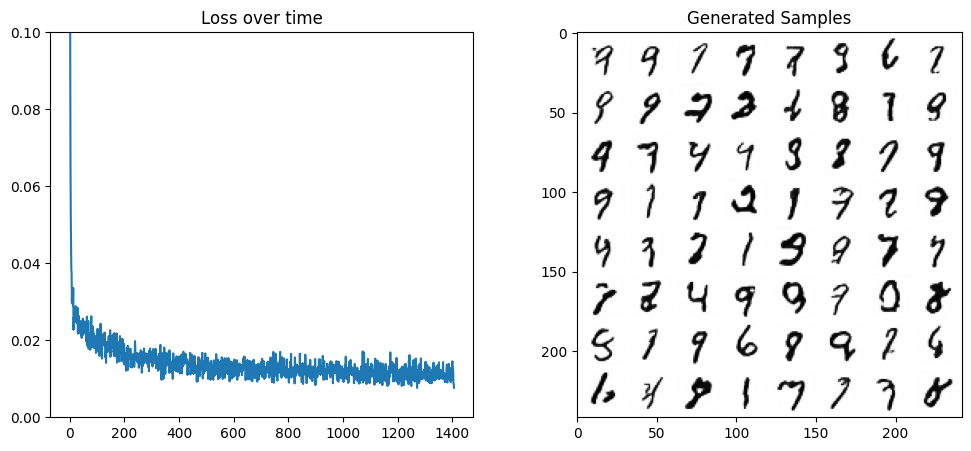

In [17]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

这看起来比我们的第一组结果好多了！您可以尝试调整UNet配置或更长时间的训练，以获得更好的性能。

### 损坏过程

DDPM论文描述了一个为每个“timestep”添加少量噪声的损坏过程。 为某些timestep给定 $x_{t-1}$ ,我们可以得到一个噪声稍稍增加的 $x_t$:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


这就是说，我们取 $x_{t-1}$, 给他一个$\sqrt{1 - \beta_t}$ 的系数，然后加上带有 $\beta_t$系数的噪声。 这里 $\beta$ 是根据一些管理器来为每一个t设定的，来决定每一个迭代周期中添加多少噪声。 现在，我们不想把这个推演进行500次来得到 $x_{500}$，所以我们用另一个公式来根据给出的 $x_0$ 计算得到任意t时刻的 $x_t$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

数学符号看起来总是很吓人！幸运的是，调度器为我们处理了所有这些（取消下一个单元格的注释以检查代码）。我们可以画出 $\sqrt{\bar{\alpha}_t}$ (标记为 `sqrt_alpha_prod`) 和 $\sqrt{(1 - \bar{\alpha}_t)}$ (标记为 `sqrt_one_minus_alpha_prod`) 来看一下输入(x)与噪声是如何在不同迭代周期中量化和叠加的:


In [18]:
#??noise_scheduler.add_noise

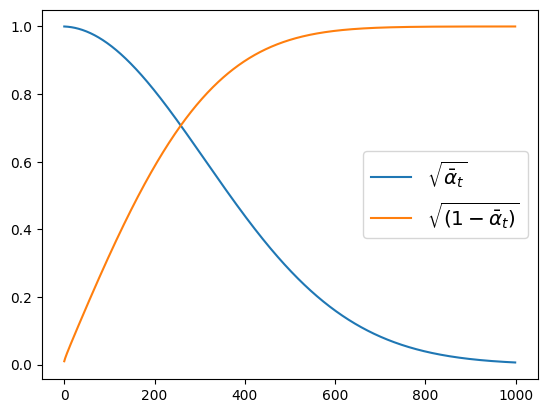

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

一开始, 噪声x里绝大部分都是x自身的值  (sqrt_alpha_prod ~= 1)，但是随着时间的推移，x的成分逐渐降低而噪声的成分逐渐增加。与我们根据`amount`对x和噪声进行线性混合不同，这个噪声的增加相对较快。我们可以在一些数据上看到这一点：

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


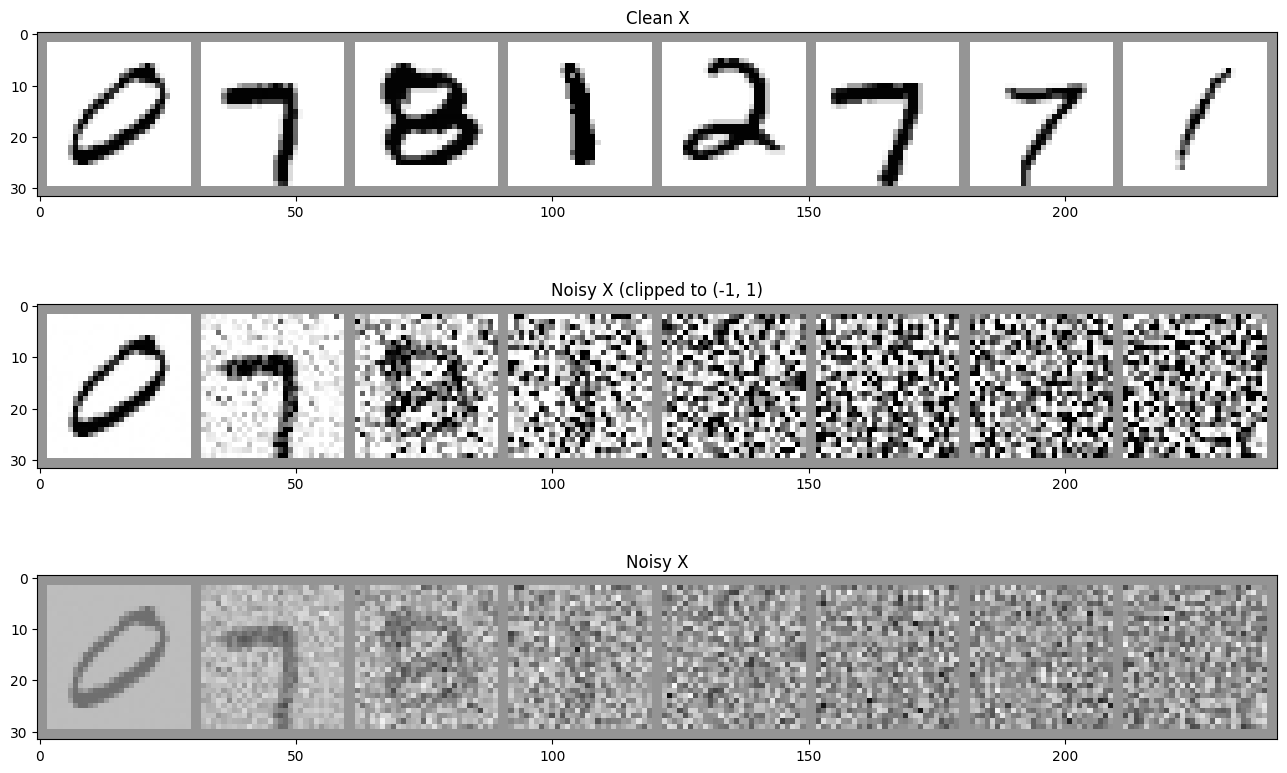

In [20]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

在运行中的另一个变化：在DDPM版本中，加入的噪声是取自一个高斯分布（来自均值0方差1的torch.randn），而不是在我们原始 `corrupt`函数中使用的 0-1之间的均匀分布（torch.rand），当然对训练数据做正则化也可以理解。在另一篇笔记中，你会看到 `Normalize(0.5, 0.5)`函数在变化列表中，它把图片数据从(0, 1) 区间映射到 (-1, 1)，对我们的目标来说也‘足够用了’。我们在此篇笔记中没使用这个方法，但在上面的可视化中为了更好的展示添加了这种做法。

### 训练目标

在我们的玩具示例中，我们让模型尝试预测去噪图像。在DDPM和许多其他扩散模型实现中，模型则会预测损坏过程中使用的噪声（在缩放之前，因此是单位方差噪声）。在代码中，它看起来像使这样：

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

你可能认为预测噪声（我们可以从中得出去噪图像的样子）等同于直接预测去噪图像。那么，为什么要这么做呢？这仅仅是为了数学上的方便吗？

这里其实还有另一些精妙之处。我们在训练过程中，会计算不同（随机选择）timestep的loss。这些不同的目标将导致这些loss的不同的“隐含权重”，其中预测噪声会将更多的权重放在较低的噪声水平上。你可以选择更复杂的目标来改变这种“隐性损失权重”。或者，您选择的噪声管理器将在较高的噪声水平下产生更多的示例。也许你让模型设计成预测“velocity”v，我们将其定义为由噪声水平影响的图像和噪声组合（请参阅“扩散模型快速采样的渐进蒸馏”- 'PROGRESSIVE DISTILLATION FOR FAST SAMPLING OF DIFFUSION MODELS'）。也许你将模型设计成预测噪声，然后基于某些因子来对loss进行缩放：比如有些理论指出可以参考噪声水平（参见“扩散模型的感知优先训练”-'Perception Prioritized Training of Diffusion Models'），或者基于一些探索模型最佳噪声水平的实验（参见“基于扩散的生成模型的设计空间说明”-'Elucidating the Design Space of Diffusion-Based Generative Models'）。

一句话解释：选择目标对模型性能有影响，现在有许多研究者正在探索“最佳”选项是什么。
目前，预测噪声（epsilon或eps）是最流行的方法，但随着时间的推移，我们很可能会看到库中支持的其他目标，并在不同的情况下使用。

### 迭代周期（Timestep）调节

UNet2DModel以x和timestep为输入。后者被转化为一个嵌入（embedding），并在多个地方被输入到模型中。

这背后的理论支持是这样的：通过向模型提供有关噪声水平的信息，它可以更好地执行任务。虽然在没有这种timestep条件的情况下也可以训练模型，但在某些情况下，它似乎确实有助于性能，目前来说绝大多数的模型实现都包括了这一输入。

### 取样（采样）

有一个模型可以用来预测在带噪样本中的噪声（或者说能预测其去噪版本），我们怎么用它来生成图像呢？

我们可以给入纯噪声，然后就希望模型能一步就输出一个不带噪声的好图像。但是，就我们上面所见到的来看，这通常行不通。所以，我们在模型预测的基础上使用足够多的小步，迭代着来每次去除一点点噪声。

具体我们怎么走这些小步，取决于使用上面取样方法。我们不会去深入讨论太多的理论细节，但是一些顶层想法是这样：
- 每一步你想走多大？也就是说，你遵循什么样的“噪声计划（噪声管理）”？
- 你只使用模型当前步的预测结果来指导下一步的更新方向吗（像DDPM，DDIM或是其他的什么那样）？你是否要使用模型来多预测几次来估计一个更高阶的梯度来更新一步更大更准确的结果（更高阶的方法和一些离散ODE处理器）？或者保留历史预测值来尝试更好的指导当前步的更新（线性多步或遗传取样器）？
- 你是否会在取样过程中额外再加一些随机噪声，或你完全已知得（deterministic）来添加噪声？许多取样器通过参数（如DDIM中的'eta'）来供用户选择。

对于扩散模型取样器的研究演进的很快，随之开发出了越来越多可以使用更少步就找到好结果的方法。勇敢和有好奇心的人可能会在浏览diffusers library中不同部署方法时感到非常有意思 [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) 或看看 [docs](https://huggingface.co/docs/diffusers/api/schedulers) 这里经常有一些相关的paper.

## 结语

希望这可以从一些不同的角度来审视扩散模型提供一些帮助。
这篇笔记是Jonathan Whitaker为Hugging Face 课程所写的，同时也有 [version included in his own course](https://johnowhitaker.github.io/tglcourse/dm1.html),“风景的生成”- 'The Generative Landscape'。如果你对从噪声和约束分类来生成样本的例子感兴趣。问题与bug可以通过GitHub issues 或 Discord来交流。 也同时欢迎通过Twitter联系 [@johnowhitaker](https://twitter.com/johnowhitaker).